# Quantum Walk on a Linear Graph with 16 Nodes 


This Jupyter Notebook demonstrates how to implement a quantum walk on a linear graph consisting of 16 nodes. The quantum walk is a quantum analog of the classical random walk and exhibits unique characteristics due to quantum superposition and interference. This notebook outlines the setup and execution of a quantum walk, employing Classiq's Python framework to define and manipulate the quantum states involved.

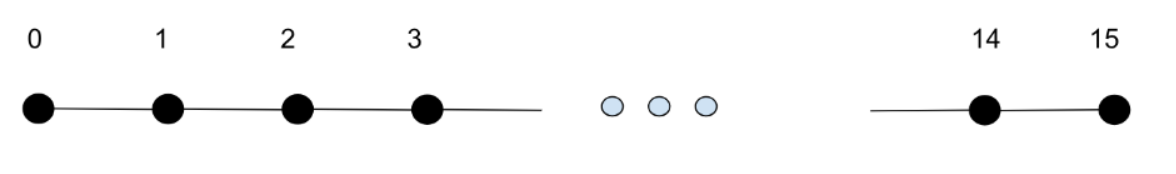

## Code Setup

The following code imports necessary modules from the Classiq framework and sets up the quantum environment for a walk on a graph with 16 nodes. It utilizes quantum functions (qfuncs) to define quantum operations.


In [11]:
from classiq import *

# Define the size of the system (number of qubits)
size = 4

@qfunc
def prepare_minus(x: QBit):
    """
    Prepare Minus State Function:
    Applies an X gate followed by a Hadamard gate to a qubit, which prepares the qubit in the |-⟩ state.

    Parameters:
        x (QBit): The qubit to be prepared in the |-⟩ state.
    """
    X(x)  # Apply Pauli-X gate to flip the qubit
    H(x)  # Apply Hadamard gate to create superposition, resulting in the |-⟩ state

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    """
    Diffuser Oracle Function:
    Applies a phase shift if the quantum number 'x' is not zero, used in the diffuser block of quantum algorithms.

    Parameters:
        aux (Output[QNum]): Auxiliary quantum number used for computation.
        x (QNum): Quantum number checked against zero to determine phase flip.
    """
    aux ^= (x != 0)  # XOR operation to flip 'aux' if 'x' is not zero

@qfunc
def zero_diffuzer(x: QNum):
    """
    Zero Diffuser Function:
    Implements a diffuser using an auxiliary qubit. It allocates a new quantum number, prepares it in the minus state, and applies a diffuser oracle.

    Parameters:
        x (QNum): Quantum number to which the diffuser is applied.
    """
    aux = QNum('aux')  # Allocate an auxiliary quantum number
    allocate(1, aux)   # Allocate one qubit to 'aux'
    # Apply the prepare_minus and diffuzer_oracle within a controlled block
    within_apply(
        compute=lambda: prepare_minus(aux),  # Prepare the 'aux' in minus state before action
        action=lambda: diffuzer_oracle(aux, x)  # Apply the diffuser oracle using 'aux'
    )


## W Operator (Walk Operator)
#### Introduction
The W Operator manages the superposition of adjacency relationships within the graph. Unlike cyclic or fully connected graphs, a linear graph with endpoints has different adjacency relationships. The first and last nodes have only one adjacent node, whereas all other internal nodes connect to two nodes (previous and next).

In [8]:
def W_iteration(i:int, vertices: QNum, adjacent_vertices: QNum):
    # Initializes the probability vector for state transitions
    prob = [0]* 2**size
    # Adjusting probabilities based on node position
    if i == 0:
        prob[i+1] = 1.0  # Only right neighbor for the first node
    elif i == ((2**size)-1):
        prob[i-1] = 1.0  # Only left neighbor for the last node
    else:
        prob[i-1] = 0.5  # Both neighbors for internal nodes
        prob[i+1] = 0.5

    print(f'State={i}, prob vec ={prob}')

    # Applying quantum operations based on the control condition
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
                compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action= lambda: zero_diffuzer(adjacent_vertices)))

def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)


## S Operator (Shift Operator)
#### Introduction
The S Operator ensures the transformation of states between edges based on the adjacency defined by the W operator. This operator is essential for moving the quantum state across the graph according to the defined probabilities.

In [9]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """
    Edge Oracle Function:
    Determines if two vertices are adjacent based on the graph's adjacency rules.
    For a line graph, a vertex is adjacent if it is directly next to another vertex.
    
    Parameters:
        res (Output[QBit]): A quantum bit that holds the result of the adjacency test.
        vertices (QNum): Quantum number representing a vertex in the graph.
        adjacent_vertices (QNum): Quantum number representing an adjacent vertex in the graph.
    """
    # Set 'res' to 1 if the vertices are directly adjacent (difference of 1 in either direction)
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    """
    Bitwise Swap Function:
    Swaps the quantum states of two arrays of qubits, effectively swapping the states of two vertices.
    
    Parameters:
        x (QArray[QBit]): First array of quantum bits.
        y (QArray[QBit]): Second array of quantum bits to be swapped with the first.
    """
    # Perform a SWAP operation for each pair of corresponding qubits in arrays 'x' and 'y'
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    """
    S Operator (Shift Operator):
    Applies a conditional swap between two vertices if they are determined to be adjacent by the edge oracle.
    
    Parameters:
        vertices (QNum): Quantum number representing a vertex in the graph.
        adjacent_vertices (QNum): Quantum number representing an adjacent vertex.
    """
    # Initialize a quantum number to hold the result of the adjacency test
    res = QNum('res')
    
    # Determine if the vertices are adjacent
    edge_oracle(res, vertices, adjacent_vertices)
    
    # If adjacent (res == 1), perform a bitwise swap of the quantum states of the vertices
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))


##     Main Quantum Function:
Sets up and initiates the quantum walk on a linear graph with 16 nodes.
This function initializes the quantum states, applies the walk and shift operators,
and integrates all components into a quantum model.

In [10]:
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    """
    Parameters:
        vertices (Output[QNum]): Quantum number array for vertices. Represents the state of each vertex.
        adjacent_vertices (Output[QNum]): Quantum number array for adjacent vertices used in quantum walk operations.
    """

    # Allocate quantum numbers for vertices with initial size.
    # 'size' is the number of bits needed to represent all vertices, in this case, log2(16) = 4.
    allocate(size, vertices)

    # Apply a Hadamard transform to each vertex to create a superposition of all possible states.
    hadamard_transform(vertices)

    # Allocate quantum numbers for adjacent vertices, which will interact with the main vertices array.
    allocate(size, adjacent_vertices)

    # Apply the W operator, which defines the walk by creating superpositions according to the adjacency matrix.
    W_operator(vertices, adjacent_vertices)

    # Apply the S operator, which includes conditional operations based on the adjacency determined by the W operator.
    S_operator(vertices, adjacent_vertices)

# Create the quantum model using the 'main' function.
# This model encapsulates the entire quantum walk operation and is ready for simulation.
qmod = create_model(main)


State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

## Simulation and Visualization


In [7]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/9bfc927c-ffe6-431c-8011-c71f4d35b8bd?version=0.43.3


## The circuit looks like : 

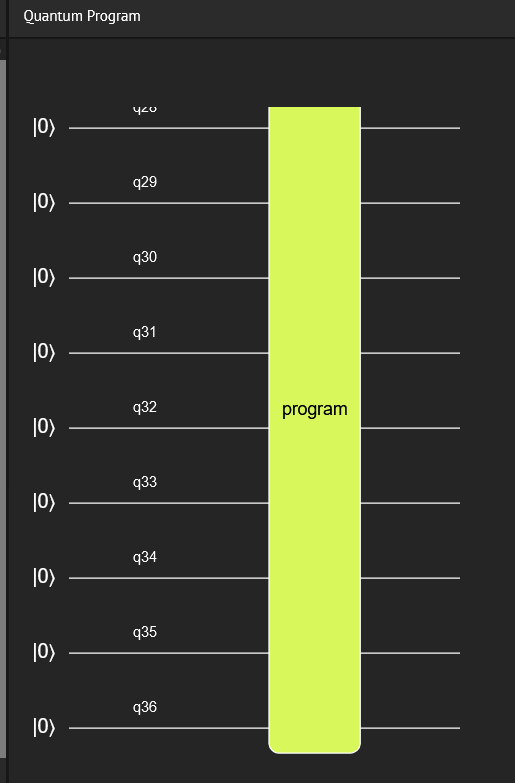

## Expanding the nodes

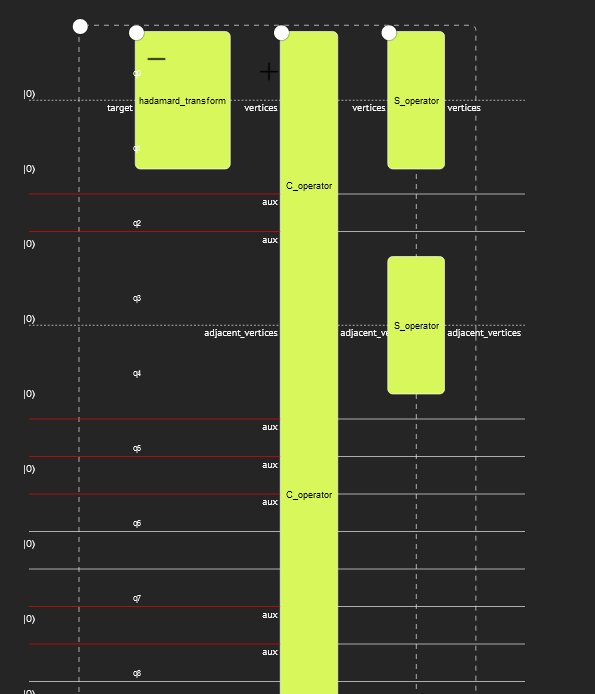

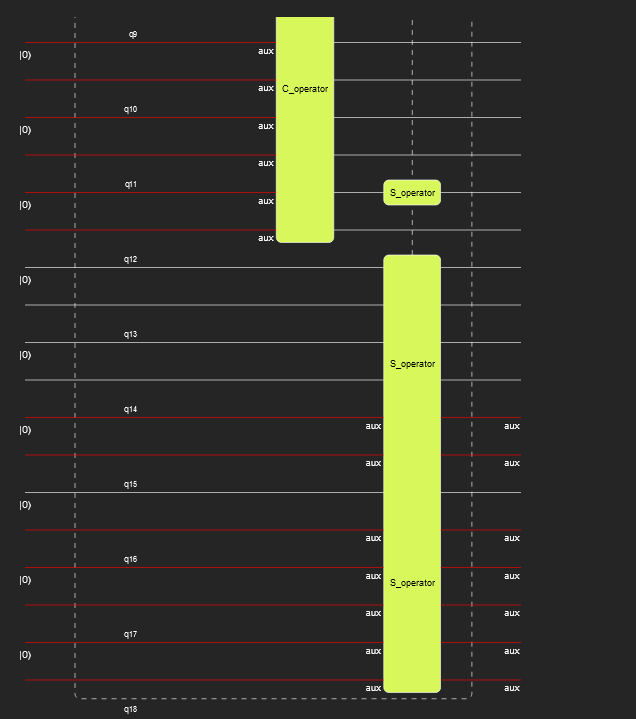

## Extended Explanation
Here, the implementation of the Shift operator is demonstrated.

The edge oracle block determines whether the current vertex and an adjacent vertex are directly connected. If they are adjacent, it activates a flag qubit to signal this connection. Should the edge oracle confirm adjacency, the bitwise swap operation is triggered, exchanging the states of the vertices and adjacent_vertices qubits. This exchange mimics the walker's transition to the adjacent vertex. The dashed control lines signify that the bitwise swap is contingent on the adjacency verification by the edge oracle, confirming that the swap only takes place if the vertices are genuinely adjacent.


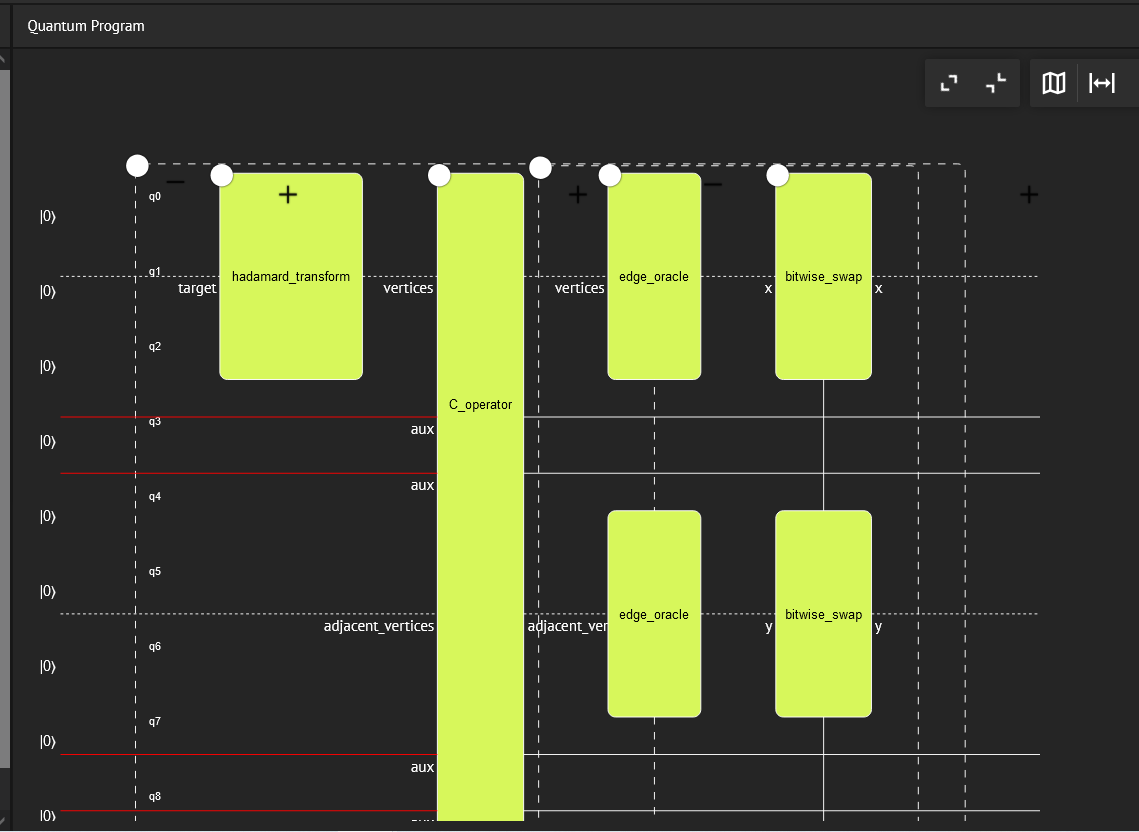

## Further Expansion
The screenshot shows a portion of the quantum circuit used for the Coin operator within the quantum random walk algorithm.

The circuit initiates by applying Hadamard gates to achieve an equal superposition across all potential states (positions). This setup ensures that the walker can potentially be located at any of the 16 nodes. The state preparation block sets up the probabilities for transitions to adjacent vertices. For every node, this function configures the probability amplitudes for the walker's movement to its adjacent nodes. The zero diffuser block implements a diffusion operator to accurately spread these probabilities. An auxiliary qubit (aux) assists in this process, with operations carried out sequentially across each node.

Unfortunately, I am unable to fit the entire circuit here but this can be reproduced by running this notebook

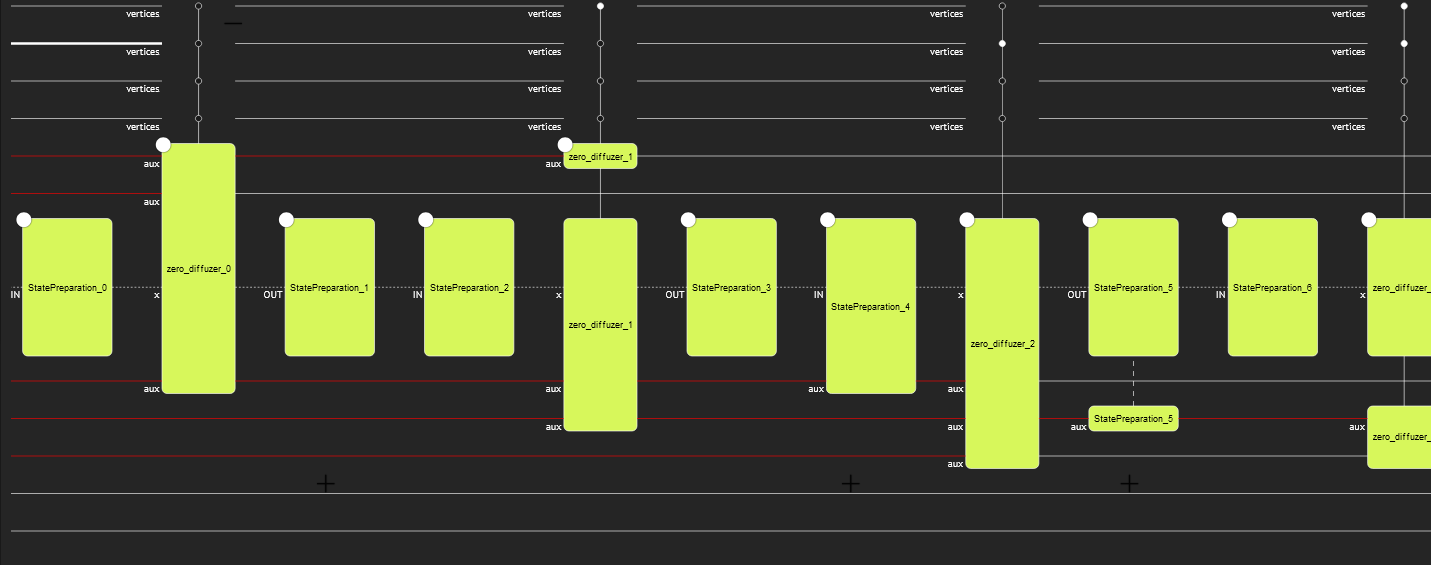

## Conclusion
This notebook provides a detailed exploration of quantum walks on a linear graph with 16 nodes, showcasing how different operators influence the walk and illustrating the quantum superposition and interference effects typical to quantum computing.